# Context-aware drift detection on news articles

## Introduction

In this notebook we show how to **detect drift on text data given a specific context** using the [context-aware MMD detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/contextmmddrift.html) ([Cobb and Van Looveren, 2022](https://arxiv.org/abs/2203.08644)). Consider the following simple example: the upcoming elections result in an increase of political news articles compared to other topics such as sports or science. Given the context (the elections), it is however not surprising that we observe this uptick. Moreover, assume we have a machine learning model which is trained to classify news topics, and this model performs well on political articles. So given that we fully expect this uptick to occur given the context, and that our model performs fine on the political news articles, we do not want to flag this type of drift in the data. **This setting corresponds more closely to many real-life settings than traditional drift detection where we make the assumption that both the reference and test data are i.i.d. samples from their underlying distributions.**

In our news topics example, each different topic such as politics, sports or weather represents a subpopulation of the data. Our context-aware drift detector can then detect changes in the data distribution which cannot be attributed to a change in the relative prevalences of these subpopulations, which we deem permissible. As a cherry on the cake, the context-aware detector allows you to understand which subpopulations are present in both the reference and test data. This allows you to obtain deep insights into the distribution underlying the test data.

Useful context (or *conditioning*) variables for the context-aware drift detector include but are not limited to:

1. **Domain or application specific** contexts such as the time of day or the weather.
2. Conditioning on the **relative prevalences of known subpopulations**, such as the frequency of political articles. It is important to note that while the relative frequency of each subpopulation might change, the distribution underlying each subpopulation cannot change.
3. Conditioning on **model predictions**. Assume we trained a classifier which tries to figure out which news topic an article belongs to. Given our model predictions we then want to understand whether our test data follows the same underlying distribution as reference instances with similar model predictions. This conditioning would also be useful in case of trending news topics which cause the model prediction distribution to shift but not necessarily the distribution within each of the news topics.
4. Conditioning on **model uncertainties** which would allow increases in model uncertainty due to drift into familiar regions of high aleatoric uncertainty (often fine) to be distinguished from that into unfamiliar regions of high epistemic uncertainty (often problematic).

The following settings will be illustrated throughout the notebook:

1. A **change in the prevalences of subpopulations** (i.e. news topics) relative to their prevalences in the training data. Contrary to traditional drift detection approaches, **the context-aware detector does not flag drift** as this change in frequency of news topics is permissible given the context provided (e.g. more political news articles around elections).
2. A **change in the underlying distribution of one or more subpopulations** takes place. While we allow changes in the prevalence of the subpopulations accounted for by the context variable, we do not allow changes of the subpopulations themselves. Let's assume that a newspaper usually has a certain tone (e.g. more conservative) when it comes to politics. If this tone changes (to less conservative) around elections (increased frequency of political news articles), then we want to **flag it as drift** since the change cannot be attributed to the context given to the detector.
3. A **change in the distribution as we observe a previously unseen news topic**. A newspaper might for instance add a classified ads section, which was not present in the reference data.

Under setting 1. we want our detector to be **well-calibrated** (a controlled False Positive Rate (FPR) and more generally a p-value which is uniformly distributed between 0 and 1) while under settings 2. and 3. we want our detector to be **powerful** and flag the drift. Lastly, we show how the detector can help you to **understand the connection between the reference and test data distributions** better.

## Data

We use the [20 newsgroup dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) which contains about 18,000 newsgroups post across 20 topics, including politics, science sports or religion.

## Requirements

The notebook requires the `umap-learn`, `torch`, `sentence-transformers`, `statsmodels`, `seaborn` and `datasets` packages to be installed, which can be done via `pip`:

In [ ]:
!pip install umap-learn torch sentence-transformers statsmodels seaborn datasets

Before we start let's fix the random seeds for reproducibility:

In [1]:
import numpy as np
import torch

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

set_seed(2022)

## Load data

First we load the data, show which classes (news topics) are present and what an instance looks like.

In [2]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)
print(f'{len(dataset.data)} documents')
print(f'{len(dataset.target_names)} categories:')
dataset.target_names

18846 documents
20 categories:


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Let's take a look at an instance from the dataset:

In [3]:
n = 1
for _, document in enumerate(dataset.data[:n]):
    category = dataset.target_names[dataset.target[_]]
    print(f'{_}. Category: {category}')
    print('---------------------------')
    print(document[:1000])
    print('---------------------------')

0. Category: rec.sport.hockey
---------------------------
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


---------------------------


## Define models and train a classifier

We embed the news posts using [SentenceTransformers](https://www.sbert.net/index.html) pre-trained embeddings and optionally add a dimensionality reduction step with [UMAP](https://umap-learn.readthedocs.io/en/stable/). UMAP also allows to leverage reference data labels.

We define respectively a generic clustering model using UMAP, a model to embed the text input using pre-trained *SentenceTransformers* embeddings, a text classifier and a utility function to place the data on the right device.

In [4]:
from sentence_transformers import SentenceTransformer
import torch.nn as nn
import umap


class UMAPModel:
    def __init__(
        self, 
        n_neighbors: int = 10,
        n_components: int = 2,
        metric: str = 'euclidean',
        min_dist: float = .1,
        **kwargs: dict
    ) -> None:
        super().__init__()
        kwargs = kwargs if isinstance(kwargs, dict) else dict()
        kwargs.update(
            n_neighbors=n_neighbors,
            n_components=n_components,
            metric=metric,
            min_dist=min_dist
        )
        self.model = umap.UMAP(**kwargs)
    
    def fit(self, x: np.ndarray, y: np.ndarray = None) -> None:
        """ Fit UMAP embedding. A combination of labeled and unlabeled data
        can be passed. Unlabeled instances are equal to -1. """
        self.model.fit(x, y=y)
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        """ Transform the input x to the embedding space. """
        return self.model.transform(x)


class EmbeddingModel:
    def __init__(
        self,
        model_name: str = 'paraphrase-MiniLM-L6-v2',  # https://www.sbert.net/docs/pretrained_models.html
        max_seq_length: int = 200,
        batch_size: int = 32,
        device: torch.device = None
    ) -> None:
        if not isinstance(device, torch.device):
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encode_text = SentenceTransformer(model_name).to(device)
        self.encode_text.max_seq_length = max_seq_length
        self.batch_size = batch_size
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.encode_text.encode(x, convert_to_numpy=True, batch_size=self.batch_size,
                                       show_progress_bar=False)

    
class Classifier(nn.Module):
    def __init__(
        self, 
        model_name: str = 'paraphrase-MiniLM-L6-v2',
        max_seq_length: int = 200,
        n_classes: int = 20
    ) -> None:
        """ Text classification model. Note that we do not train the embedding backbone. """
        super().__init__()
        self.encode_text = SentenceTransformer(model_name)
        self.encode_text.max_seq_length = max_seq_length
        for param in self.encode_text.parameters():
            param.requires_grad = False
        self.head = nn.Sequential(nn.Linear(384, 256), nn.LeakyReLU(.1), nn.Dropout(.5), nn.Linear(256, 20))
        
    def forward(self, tokens) -> torch.Tensor:
        return self.head(self.encode_text(tokens)['sentence_embedding'])

    
def batch_to_device(batch: dict, target_device: torch.device):
    """ Send a pytorch batch to a device (CPU/GPU). """
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch[key] = batch[key].to(target_device)
    return batch

First we train a classifier on a small subset of the data. The aim of the classifier is to predict the news topic of each instance. Below we define a few simple training and evaluation functions.

In [5]:
def train_model(model, loader, epochs=3, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for x, y in tqdm(loader):
            tokens, y = tokenize(x), y.to(device)
            y_hat = clf(tokens)
            optimizer.zero_grad()
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            
def eval_model(model, loader, verbose=1):
    model.eval()
    logits, labels = [], []
    with torch.no_grad():
        if verbose == 1:
            loader = tqdm(loader)
        for x, y in loader:
            tokens = tokenize(x)
            y_hat = model(tokens)
            logits += [y_hat.cpu().numpy()]
            labels += [y.cpu().numpy()]
    logits = np.concatenate(logits, 0)
    preds = np.argmax(logits, 1)
    labels = np.concatenate(labels, 0)
    if verbose == 1:
        accuracy = (preds == labels).mean()
        print(f'Accuracy: {accuracy:.3f}')
    return logits, preds

We now split the data in 2 sets. The first set (`x_train`) we will use to train our text classifier, and the second set (`x_drift`) is held out to test our drift detector on.

In [6]:
n_all = len(dataset.data)
n_train = 5000  # nb of instances to train news topic classifier on
idx_train = np.random.choice(n_all, size=n_train, replace=False)
idx_keep = np.setdiff1d(np.arange(n_all), idx_train)
# data used for model training
x_train, y_train = [dataset.data[_] for _ in idx_train], dataset.target[idx_train]
# data used for drift detection
x_drift, y_drift = [dataset.data[_] for _ in idx_keep], dataset.target[idx_keep]
n_drift = len(x_drift)

Let's train our classifier. The classifier consists of a simple MLP head on top of a pre-trained SentenceTransformer model as the backbone. The SentenceTransformer remains frozen during training and only the MLP head is finetuned.

In [7]:
from alibi_detect.utils.pytorch import TorchDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import Dict, List

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clf = Classifier().to(device)
train_loader = DataLoader(TorchDataset(x_train, y_train), batch_size=32, shuffle=True)
drift_loader = DataLoader(TorchDataset(x_drift, y_drift), batch_size=32, shuffle=False)

def tokenize(x: List[str]) -> Dict[str, torch.Tensor]:
    tokens = clf.encode_text.tokenize(x)
    return batch_to_device(tokens, device)

train_model(clf, train_loader, epochs=5)
clf.eval()
_, _ = eval_model(clf, train_loader)
_, _ = eval_model(clf, drift_loader)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda
  1%|          | 3/433 [00:00<00:19, 22.47it/s]

Accuracy: 0.806


100%|██████████| 433/433 [00:21<00:00, 19.97it/s]

Accuracy: 0.730


## Detector calibration under no change

We start with an example where no drift occurs and the reference and test data are both sampled randomly from all news topics. Under this scenario, we expect no drift to be detected by either a *normal* MMD detector or by the context-aware MMD detector.

First we define some helper functions. The first one visualises the clustered text data while the second function samples disjoint reference and test sets with a specified number of instances per class (i.e. per news topic).

In [8]:
import matplotlib.pyplot as plt


def plot_clusters(x: np.ndarray, y: np.ndarray, classes: list, title: str = None) -> None:
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.scatter(*x.T, s=0.3, c=y, cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    nc = len(classes)
    cbar = plt.colorbar(boundaries=np.arange(nc+1)-0.5)
    cbar.set_ticks(np.arange(nc))
    cbar.set_ticklabels(classes)
    if title:
        plt.title(title);
        

def split_data(x, y, n_ref_c, n_test_c, seed=None, y2=None, return_idx=False):
    
    if seed:
        np.random.seed(seed)
    
    # split data by class
    n_c = len(np.unique(y))
    idx_c = {_: np.where(y == _)[0] for _ in range(n_c)}
    
    # convert nb instances per class to a list if needed
    n_ref_c = [n_ref_c] * n_c if isinstance(n_ref_c, int) else n_ref_c
    n_test_c = [n_test_c] * n_c if isinstance(n_test_c, int) else n_test_c
    
    # sample reference, test and held out data
    idx_ref, idx_test, idx_held = [], [], []
    for _ in range(n_c):
        idx = np.random.choice(idx_c[_], size=len(idx_c[_]), replace=False)
        idx_ref.append(idx[:n_ref_c[_]])
        idx_test.append(idx[n_ref_c[_]:n_ref_c[_] + n_test_c[_]])
        idx_held.append(idx[n_ref_c[_] + n_test_c[_]:])
    idx_ref = np.concatenate(idx_ref)
    idx_test = np.concatenate(idx_test)
    idx_held = np.concatenate(idx_held)
    x_ref, y_ref = [x[_] for _ in idx_ref], y[idx_ref]
    x_test, y_test = [x[_] for _ in idx_test], y[idx_test]
    x_held, y_held = [x[_] for _ in idx_held], y[idx_held]
    if y2 is not None:
        y_ref2, y_test2, y_held2 = y2[idx_ref], y2[idx_test], y2[idx_held]
        return (x_ref, y_ref, y_ref2), (x_test, y_test, y_test2), (x_held, y_held, y_held2)
    elif not return_idx:
        return (x_ref, y_ref), (x_test, y_test), (x_held, y_held)
    else:
        return idx_ref, idx_test, idx_held

In [9]:
# initially assume equal distribution of topics in the reference data
n_ref, n_test = 2000, 2000
classes = dataset.target_names
n_classes = len(classes)
n_ref_c = n_ref // n_classes
n_test_c = n_test // n_classes

(x_ref, y_ref), (x_test, y_test), (x_held, y_held) = split_data(x_drift, y_drift, n_ref_c, n_test_c)

We first define the embedding model using the pre-trained *SentenceTransformer* embeddings and then embed both the reference and test sets.

In [10]:
model = EmbeddingModel()
emb_ref = model(x_ref)
emb_test = model(x_test)
print(f'Shape of embedded reference and test data: {emb_ref.shape} - {emb_test.shape}')

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda


Shape of embedded reference and test data: (2000, 384) - (2000, 384)


By applying UMAP clustering on the *SentenceTransformer* embeddings, we can visually inspect the various news topic clusters. Note that we fit the clustering model on the held out data first, and then make predictions on the reference and test sets.

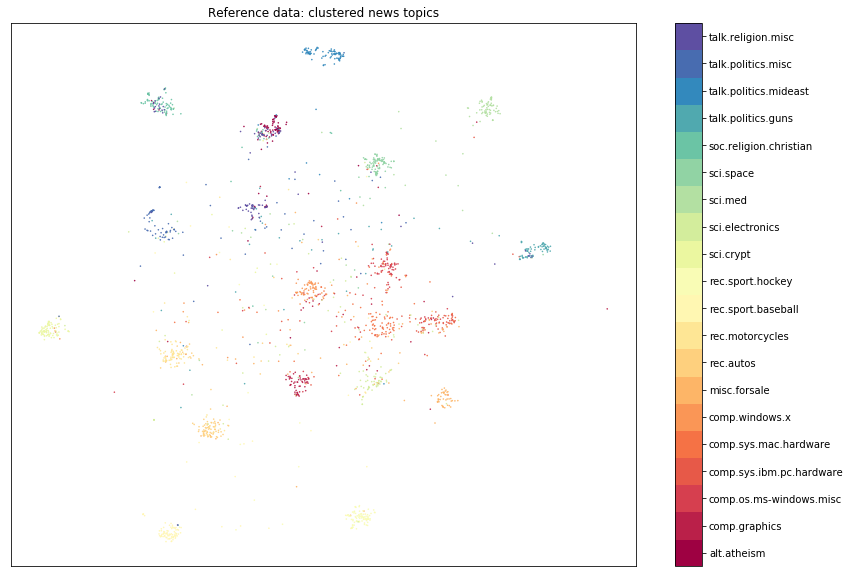

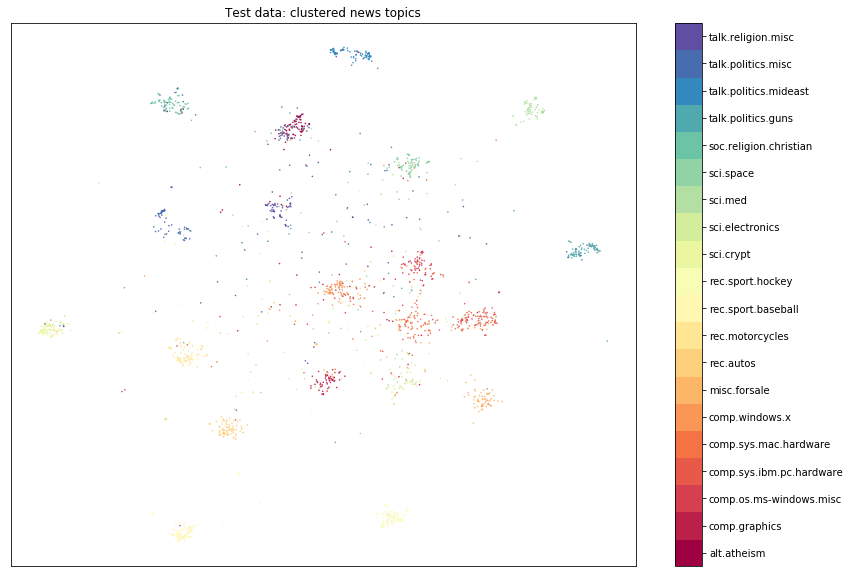

In [11]:
umap_model = UMAPModel()
emb_held = model(x_held)
umap_model.fit(emb_held, y=y_held)
cluster_ref = umap_model.predict(emb_ref)
cluster_test = umap_model.predict(emb_test)
plot_clusters(cluster_ref, y_ref, classes, title='Reference data: clustered news topics')
plot_clusters(cluster_test, y_test, classes, title='Test data: clustered news topics')

We can visually see that the reference and test set are made up of similar clusters of data, grouped by news topic. As a result, we would not expect drift to be flagged. If the data distribution did not change, we can expect the p-value distribution of our statistical test to be uniformly distributed between 0 and 1. So let's see if this assumption holds.

Importantly, first we need to **define our context variable** for the context-aware MMD detector. In our experiments we allow the relative prevalences of subpopulations to vary while the distributions underlying each of the subpopulations remain unchanged. To achieve this we **condition on the prediction probabilities of the classifier we trained earlier to distinguish each of the 20 different news topics**. We can do this because the prediction probabilities can account for the frequency of occurrence of each of the topics (be it imperfectly given our classifier makes the occasional mistake).

In [12]:
from scipy.special import softmax

def context(x: List[str], y: np.ndarray):  # y only needed for the data loader
    """ Condition on classifier prediction probabilities. """
    loader = DataLoader(TorchDataset(x, y), batch_size=32, shuffle=False)
    logits = eval_model(clf.eval(), loader, verbose=0)[0]
    return softmax(logits, -1)

Before we set off our experiments, we embed all the instances in `x_drift` and compute all contexts `c_drift` so we don't have to call our transformer model every single pass in the for loop.

In [13]:
emb_drift = model(x_drift)
c_drift = context(x_drift, y_drift)

In [14]:
from alibi_detect.cd import MMDDrift, ContextMMDDrift

n_runs = 50  # number of drift detection runs, each with a different reference and test sample

p_vals_mmd, p_vals_cad = [], []
for _ in tqdm(range(n_runs)):
    
    # sample data
    idx = np.random.choice(n_drift, size=n_drift, replace=False)
    idx_ref, idx_test = idx[:n_ref], idx[n_ref:n_ref+n_test]
    emb_ref, c_ref = emb_drift[idx_ref], c_drift[idx_ref]
    emb_test, c_test = emb_drift[idx_test], c_drift[idx_test]
    
    # mmd drift detector
    dd_mmd = MMDDrift(emb_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_mmd = dd_mmd.predict(emb_test)
    p_vals_mmd.append(preds_mmd['data']['p_val'])
    
    # context-aware mmd drift detector 
    dd_cad = ContextMMDDrift(emb_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_cad = dd_cad.predict(emb_test, c_test)
    p_vals_cad.append(preds_cad['data']['p_val'])
    
p_vals_mmd = np.array(p_vals_mmd)
p_vals_cad = np.array(p_vals_cad)

100%|██████████| 50/50 [19:42<00:00, 23.66s/it]


The below figure of the [Q-Q (Quantile-Quantile) plots](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) of a random sample from the uniform distribution *U[0,1]* against the obtained p-values from the vanilla and context-aware MMD detectors illustrate how well both detectors are calibrated. A perfectly calibrated detector should have a Q-Q plot which closely follows the diagonal. Only the middle plot in the grid shows the detector's p-values. The other plots correspond to *n_runs* p-values actually sampled from *U[0,1]* to contextualise how well the central plot follows the diagonal given the limited number of samples.

As expected we can see that both the normal MMD and the context-aware MMD detectors are well-calibrated.

In [15]:
import statsmodels.api as sm
from scipy.stats import uniform


def plot_p_val_qq(p_vals: np.ndarray, title: str) -> None:
    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(12,10))
    fig.suptitle(title)
    n = len(p_vals)
    for i in range(9):
        unifs = p_vals if i==4 else np.random.rand(n)
        sm.qqplot(unifs, uniform(), line='45', ax=axes[i//3,i%3])
        if i//3 < 2:
            axes[i//3,i%3].set_xlabel('')
        if i%3 != 0:
            axes[i//3,i%3].set_ylabel('')

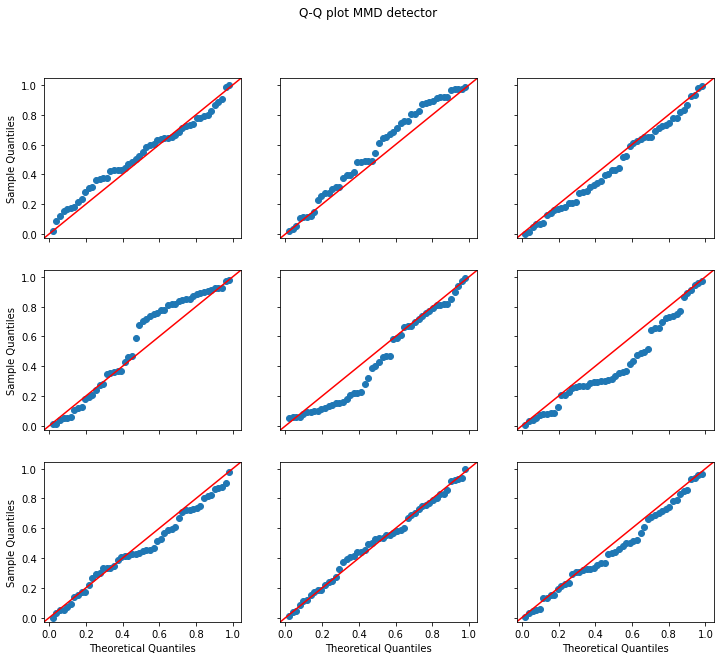

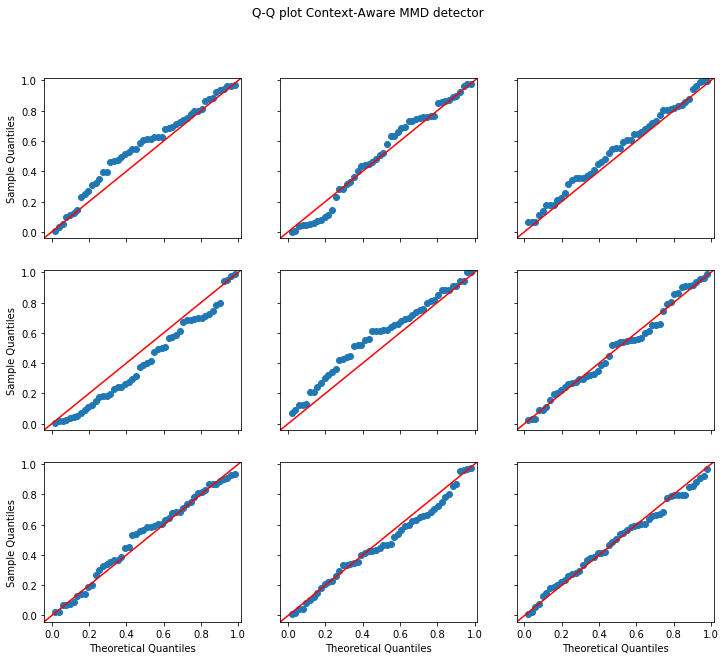

In [16]:
plot_p_val_qq(p_vals_mmd, 'Q-Q plot MMD detector')
plot_p_val_qq(p_vals_cad, 'Q-Q plot Context-Aware MMD detector')

## Changing the relative subpopulation prevalence

We now focus our attention on a more realistic problem where the relative frequency of one or more subpopulations (i.e. news topics) is changing in a way which can be attributed to external events. Importantly, the distribution underlying each subpopulation (e.g. the distribution of *hockey* news itself) remains unchanged, only its frequency changes.

In our example we assume that the World Series and Stanley Cup coincide on the calendar leading to a spike in news articles on respectively baseball and hockey. Furthermore, there is not too much news on Mac or Windows since there are no new releases or products planned anytime soon.

In [17]:
n_ref_c = 2000 // n_classes
n_test_c = [100] * n_classes
n_test_c[4], n_test_c[5] = 50, 50  # few stories on Mac/Windows
n_test_c[9], n_test_c[10] = 150, 150  # more stories on baseball/hockey

In [18]:
n_runs = 50

p_vals_mmd, p_vals_cad = [], []
for _ in tqdm(range(n_runs)):
    
    # sample data
    idx_ref, idx_test, _ = split_data(x_drift, y_drift, n_ref_c, n_test_c, return_idx=True)
    emb_ref, c_ref = emb_drift[idx_ref], c_drift[idx_ref]
    emb_test, c_test = emb_drift[idx_test], c_drift[idx_test]
    
    # mmd drift detector
    dd_mmd = MMDDrift(emb_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_mmd = dd_mmd.predict(emb_test)
    p_vals_mmd.append(preds_mmd['data']['p_val'])
    
    # context-aware mmd drift detector 
    dd_cad = ContextMMDDrift(emb_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_cad = dd_cad.predict(emb_test, c_test)
    p_vals_cad.append(preds_cad['data']['p_val'])
    
p_vals_mmd = np.array(p_vals_mmd)
p_vals_cad = np.array(p_vals_cad)

100%|██████████| 50/50 [19:51<00:00, 23.83s/it]


While the **context-aware detector remains well calibrated**, the MMD detector consistently flags drift (low p-values). Note that this is the expected behaviour since the vanilla MMD detector cannot take any external context into account and correctly detects that the reference and test data do not follow the same underlying distribution.

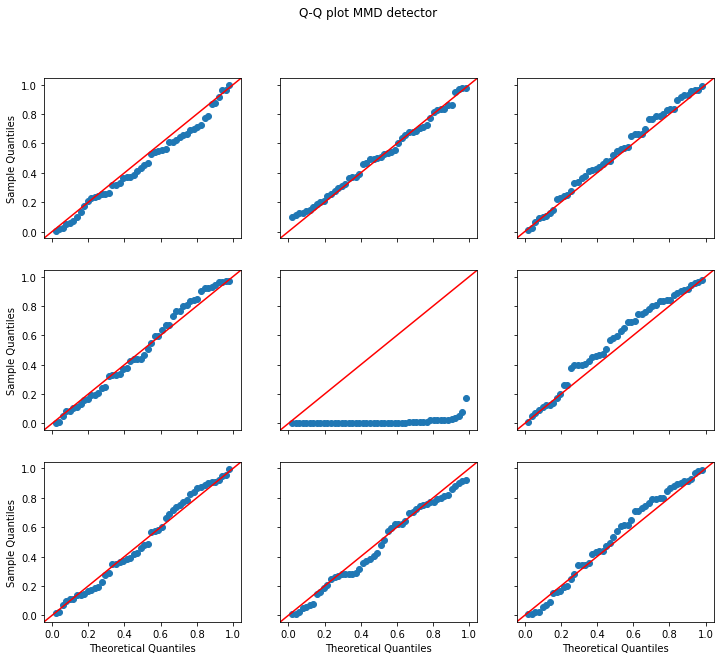

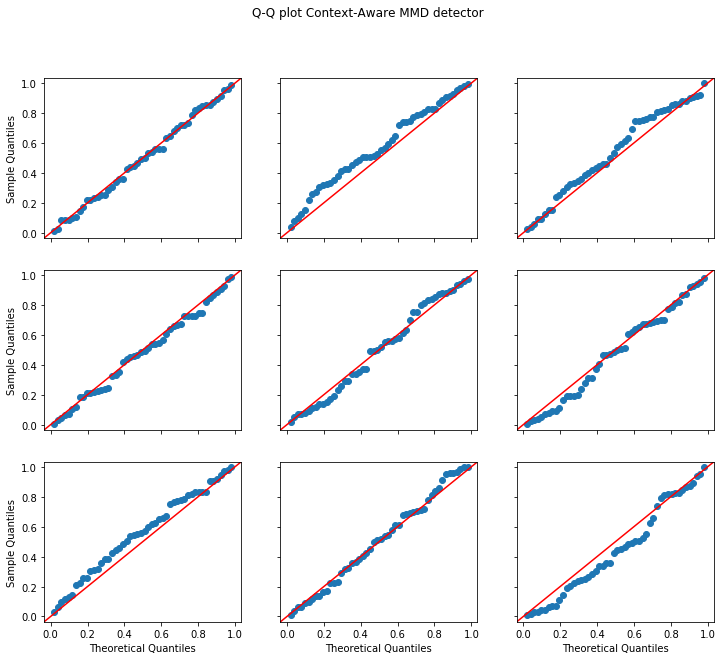

In [19]:
plot_p_val_qq(p_vals_mmd, 'Q-Q plot MMD detector')
plot_p_val_qq(p_vals_cad, 'Q-Q plot Context-Aware MMD detector')

We can also easily see this on the plot below where the p-values of the context-aware detector are uniformly distributed while the MMD detector's p-values are consistently close to 0. Note that we limited the y-axis range to make the plot easier to read.

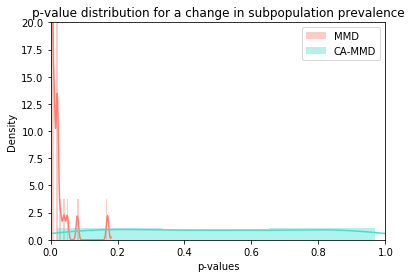

In [20]:
import seaborn as sns

def plot_hist(
    p_vals: List[np.ndarray],
    title: str,
    colors: List[str] = ['salmon', 'turquoise'],
    methods: List[str] = ['MMD', 'CA-MMD']
):
    for p_val, method, color in zip(p_vals, methods, colors):
        sns.distplot(p_val, color=color, norm_hist=True, kde=True, label=f'{method}', hist=True)
        plt.legend(loc='upper right')
    plt.xlim(0, 1)
    plt.ylim(0, 20)
    plt.ylabel('Density')
    plt.xlabel('p-values')
    plt.title(title)
    plt.show();
    
p_vals = [p_vals_mmd, p_vals_cad]
title = 'p-value distribution for a change in subpopulation prevalence'
plot_hist(p_vals, title)

## Changing the subpopulation distribution

In the following example we change the distribution of one or more of the underlying subpopulations. Notice that now we do want to **flag drift** since our context variable, which permits changes in relative subpopulation prevalences, can no longer explain the change in distribution. 

Imagine our news topic classification model is not as granular as before and instead of the 20 categories only predicts the 6 *super* classes, organised by subject matter:

1. **Computers**: comp.graphics; comp.os.ms-windows.misc; comp.sys.ibm.pc.hardware; comp.sys.mac.hardware; comp.windows.x
2. **Recreation**: rec.autos; rec.motorcycles; rec.sport.baseball; rec.sport.hockey
3. **Science**: sci.crypt; sci.electronics; sci.med; sci.space
4. **Miscellaneous**:  misc.forsale
5. **Politics**: talk.politics.misc; talk.politics.guns; talk.politics.mideast
6. **Religion**: talk.religion.misc; talk.atheism; soc.religion.christian


What if baseball and hockey become less popular and the distribution underlying the *Recreation* class changes? We will want to detect this as the change in distributions of the subpopulations (the 6 super classes) cannot be explained anymore by the context variable.

In [21]:
# map the original target labels to super classes
class_map = {
    0: [1, 2, 3, 4, 5],
    1: [7, 8, 9, 10],
    2: [11, 12, 13, 14],
    3: [6],
    4: [16, 17, 18],
    5: [0, 15, 19]
}

def map_to_super(y: np.ndarray):
    y_super = np.zeros_like(y)
    for k, v in class_map.items():
        for _ in v:
            idx_chg = np.where(y == _)[0]
            y_super[idx_chg] = k
    return y_super

y_drift_super = map_to_super(y_drift)
n_super = len(list(class_map.keys()))

In order to reuse our pretrained classifier for the super classes, we add the following helper function to map the predictions on the super classes and return one-hot encoded predictions over the 6 super classes. Note that our context variable now changes from a probability distribution over the 20 news topics to a one-hot encoded representation over the 6 super classes.

In [22]:
def ohe_super_preds(x: List[str], y: np.ndarray):
    classes = np.argmax(context(x, y), -1)  # class predictions
    classes_super = map_to_super(classes)  # map to super classes
    return np.eye(n_super, dtype=np.float32)[classes_super]  # return OHE

In [23]:
n_ref_c, n_test_c = 1000 // n_super, 1000 // n_super
n_runs = 50

p_vals_mmd, p_vals_cad = [], []
for _ in tqdm(range(n_runs)):
    
    # sample data
    (x_ref, y_ref, y_ref2), (x_test, y_test, y_test2), (x_held, y_held, y_held2) = \
        split_data(x_drift, y_drift_super, n_ref_c, n_test_c, y2=y_drift)

    # remove baseball and hockey from the recreation super class in the test set
    idx_bb, idx_hock = np.where(y_test2 == 9)[0], np.where(y_test2 == 10)[0]
    idx_remove = np.concatenate([idx_bb, idx_hock], 0)
    x_test = [x_test[_] for _ in np.arange(len(x_test)) if _ not in idx_remove]
    y_test = np.delete(y_test, idx_remove)
    
    # embed text
    emb_ref = model(x_ref)
    emb_test = model(x_test)
    
    # mmd drift detector
    dd_mmd = MMDDrift(emb_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_mmd = dd_mmd.predict(emb_test)
    p_vals_mmd.append(preds_mmd['data']['p_val'])
    
    # context-aware mmd drift detector 
    c_ref = ohe_super_preds(x_ref, y_ref)
    c_test = ohe_super_preds(x_test, y_test)
    dd_cad = ContextMMDDrift(emb_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_cad = dd_cad.predict(emb_test, c_test)
    p_vals_cad.append(preds_cad['data']['p_val'])
    
p_vals_mmd = np.array(p_vals_mmd)
p_vals_cad = np.array(p_vals_cad)

100%|██████████| 50/50 [08:43<00:00, 10.47s/it]


We can see that the context-aware detector is powerful to detect changes in the distributions of the subpopulations.

Power at 5.0% significance level
MMD: 0.940
Context-aware MMD: 1.000


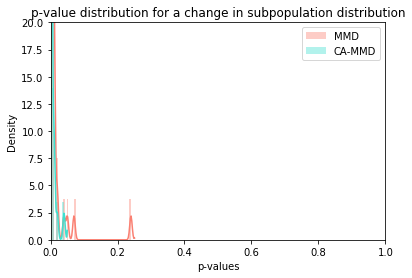

In [24]:
threshold = .05
print(f'Power at {threshold * 100}% significance level')
print(f'MMD: {(p_vals_mmd < threshold).mean():.3f}')
print(f'Context-aware MMD: {(p_vals_cad < threshold).mean():.3f}')

p_vals = [p_vals_mmd, p_vals_cad]
title = 'p-value distribution for a change in subpopulation distribution'
plot_hist(p_vals, title)

## Detect unseen topics

Next we illustrate the effectiveness of the context-aware detector to detect new topics which are not present in the reference data. Obviously we also want to **flag drift** in this case. As an example we introduce movie reviews in the test data.

In [25]:
from datasets import load_dataset

dataset = load_dataset("imdb")
x_imdb = dataset['train']['text']
n_imdb = len(x_imdb)

n_test_imdb = 100
n_ref_c = 1000 // n_classes
n_test_c = 1000 // n_classes

INFO:filelock:Lock 140307109683280 acquired on /home/avl/.cache/huggingface/datasets/171cb999feb3108c3f7838b78aae3d1d5c3a5ecdf15c775e36c4332131ccbcec.c39acffee84b8d7965ae2e5269ad438ebdb9a40b0607f38a5fdd81b1f8607864.py.lock
INFO:filelock:Lock 140307109683280 released on /home/avl/.cache/huggingface/datasets/171cb999feb3108c3f7838b78aae3d1d5c3a5ecdf15c775e36c4332131ccbcec.c39acffee84b8d7965ae2e5269ad438ebdb9a40b0607f38a5fdd81b1f8607864.py.lock
INFO:filelock:Lock 140306987154768 acquired on /home/avl/.cache/huggingface/datasets/_home_avl_.cache_huggingface_datasets_imdb_plain_text_1.0.0_90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3.lock
INFO:filelock:Lock 140306987154768 released on /home/avl/.cache/huggingface/datasets/_home_avl_.cache_huggingface_datasets_imdb_plain_text_1.0.0_90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3.lock
INFO:filelock:Lock 140306987340496 acquired on /home/avl/.cache/huggingface/datasets/_home_avl_.cache_huggingface_datasets_i

In [28]:
n_runs = 50

p_vals_mmd, p_vals_cad = [], []
for _ in tqdm(range(n_runs)):
    
    # sample data
    idx_ref, idx_test, _ = split_data(x_drift, y_drift, n_ref_c, n_test_c, return_idx=True)
    emb_ref, c_ref = emb_drift[idx_ref], c_drift[idx_ref]
    emb_test, c_test = emb_drift[idx_test], c_drift[idx_test]
    
    # add random imdb reviews to the test data
    idx_imdb = np.random.choice(n_imdb, n_test_imdb, replace=False)
    x_imdb_sample = [x_imdb[_] for _ in idx_imdb]
    emb_imdb = model(x_imdb_sample)
    c_imdb = context(x_imdb_sample, np.zeros(len(x_imdb_sample)))  # value second arg does not matter
    emb_test = np.concatenate([emb_test, emb_imdb], 0)
    c_test = np.concatenate([c_test, c_imdb], 0)
    
    # mmd drift detector
    dd_mmd = MMDDrift(emb_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_mmd = dd_mmd.predict(emb_test)
    p_vals_mmd.append(preds_mmd['data']['p_val'])
    
    # context-aware mmd drift detector
    dd_cad = ContextMMDDrift(emb_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_cad = dd_cad.predict(emb_test, c_test)
    p_vals_cad.append(preds_cad['data']['p_val'])
    
p_vals_mmd = np.array(p_vals_mmd)
p_vals_cad = np.array(p_vals_cad)

100%|██████████| 50/50 [04:50<00:00,  5.81s/it]


In [29]:
threshold = .05
print(f'Power at {threshold * 100}% significance level')
print(f'MMD: {(p_vals_mmd < threshold).mean():.3f}')
print(f'Context-aware MMD: {(p_vals_cad < threshold).mean():.3f}')

Power at 5.0% significance level
MMD: 1.000
Context-aware MMD: 0.960



## Changing the context variable

So far we have conditioned the context-aware detector on the model predictions. There are however many other useful contexts possible. One such example would be to condition on the predictions of an unsupervised clustering algorithm. To facilitate this, we first apply kernel PCA on the embedding vectors, followed by a Gaussian mixture model which clusters the data into 6 classes (same as the super classes). We will test both the calibration under the null hypothesis (no distribution change) as well as the power when a new topic (movie reviews) is injected.

In [30]:
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture

# embed training data
emb_train = model(x_train)

# apply kernel PCA to reduce dimensionality
kernel_pca = KernelPCA(n_components=10, kernel='linear')
kernel_pca.fit(emb_train)
emb_train_pca = kernel_pca.transform(emb_train)
emb_drift_pca = kernel_pca.transform(emb_drift)

# cluster the data
y_train_super = map_to_super(y_train)
n_clusters = len(np.unique(y_train_super))
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=2022)
gmm.fit(emb_train_pca)
c_all_proba = gmm.predict_proba(emb_drift_pca)
c_all_class = gmm.predict(emb_drift_pca)

Next we change the number of instances in each cluster between the reference and test sets. Note that we do not alter the underlying distribution of each of the clusters, just the frequency. 

In [31]:
# determine cluster proportions for the reference and test samples
n_ref_c = [100, 100, 100, 100, 100, 100]
n_test_c = [50, 50, 100, 25, 75, 25]

def sample_from_clusters():
    idx_ref, idx_test = [], []
    for _, (i_ref, i_test) in enumerate(zip(n_ref_c, n_test_c)):
        idx_c = np.where(c_all_class == _)[0]
        idx_shuffle = np.random.choice(idx_c, size=len(idx_c), replace=False)
        idx_ref.append(idx_shuffle[:i_ref])
        idx_test.append(idx_shuffle[i_ref:i_ref+i_test])
    idx_ref = np.concatenate(idx_ref, 0)
    idx_test = np.concatenate(idx_test, 0)
    c_ref = c_all_proba[idx_ref]
    c_test = c_all_proba[idx_test]
    emb_ref = emb_drift[idx_ref]
    emb_test = emb_drift[idx_test]
    return c_ref, c_test, emb_ref, emb_test

Now we run the experiment and show the context-aware detector's calibration when changing the cluster frequencies. We also show how the usual MMD detector will consistently flag drift. Furthermore, we inject instances from the movie reviews dataset and illustrate that the context-aware detector remains powerful when the underlying cluster distribution changes (by including a previously unseen topic).

In [33]:
n_test_imdb = 100  # number of imdb instances for each run

n_runs = 50

p_vals_null, p_vals_alt, p_vals_mmd = [], [], []
for _ in tqdm(range(n_runs)):
    
    # sample data
    c_ref, c_test_null, emb_ref, emb_test_null = sample_from_clusters()
    
    # sample random imdb reviews
    idx_imdb = np.random.choice(n_imdb, n_test_imdb, replace=False)
    x_imdb_sample = [x_imdb[_] for _ in idx_imdb]
    emb_imdb = model(x_imdb_sample)
    c_imdb = gmm.predict_proba(kernel_pca.transform(emb_imdb))
    
    # now we mix in-distribution instances with the imdb reviews
    emb_alt = np.concatenate([emb_test_null[:n_test_imdb], emb_imdb], 0)
    c_alt = np.concatenate([c_test_null[:n_test_imdb], c_imdb], 0)
    
    # mmd drift detector
    dd_mmd = MMDDrift(emb_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_mmd = dd_mmd.predict(emb_test_null)
    p_vals_mmd.append(preds_mmd['data']['p_val'])

    # context-aware mmd drift detector
    dd = ContextMMDDrift(emb_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_null = dd.predict(emb_test_null, c_test_null)
    preds_alt = dd.predict(emb_alt, c_alt)
    p_vals_null.append(preds_null['data']['p_val'])
    p_vals_alt.append(preds_alt['data']['p_val'])

p_vals_null = np.array(p_vals_null)
p_vals_alt = np.array(p_vals_alt)
p_vals_mmd = np.array(p_vals_mmd)

100%|██████████| 50/50 [02:52<00:00,  3.45s/it]


Power at 5.0% significance level
Context-aware MMD: 1.000


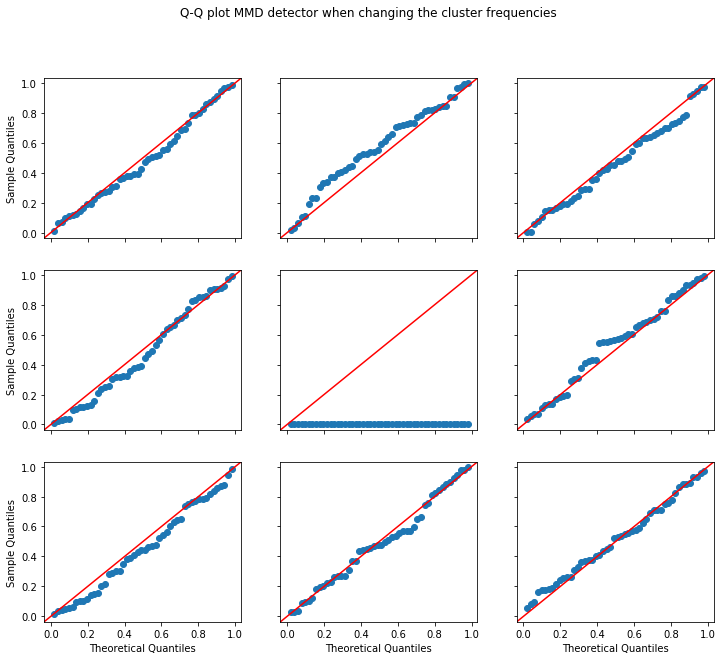

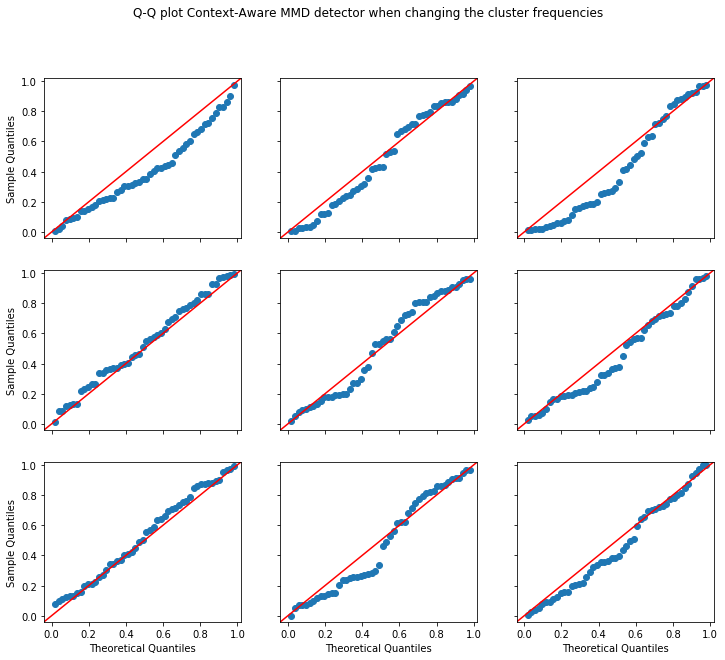

In [34]:
print(f'Power at {threshold * 100}% significance level')
print(f'Context-aware MMD: {(p_vals_alt < threshold).mean():.3f}')
plot_p_val_qq(p_vals_mmd, 'Q-Q plot MMD detector when changing the cluster frequencies')
plot_p_val_qq(p_vals_null, 'Q-Q plot Context-Aware MMD detector when changing the cluster frequencies')

## Interpretability of the context-aware detector

The test statistic $\hat{t}$ of the context-aware MMD detector can be formulated as follows: $\hat{t} = \langle K_{0,0}, W_{0,0} \rangle + \langle K_{1,1}, W_{1,1} \rangle -2\langle K_{0,1}, W_{0,1}\rangle$ where $0$ refers to the reference data, $1$ to the test data, and $W_{.,.}$ and $K_{.,.}$ are the weight and kernel matrices, respectively. The weight matrices $W_{.,.}$ allow us to focus on the distribution's subpopulations of interest. Reference instances which have similar contexts as the test data will have higher values for their entries in $W_{0,1}$ than instances with dissimilar contexts. We can therefore interpret $W_{0,1}$ as the coupling matrix between instances in the reference and the test sets. This allows us to investigate which subpopulations from the reference set are present and which are missing in the test data. If we also have a good understanding of the model performance on various subpopulations of the reference data, we could even try and use this coupling matrix to roughly proxy model performance on the unlabeled test instances. Note that in this case we would require labels from the reference data and make sure the reference instances come from the validation, not the training set. 

In the following example we only pick 2 classes to be present in the test set while all 20 are present in the reference set. We can then investigate via the coupling matrix whether the test statistic $\hat{t}$ focused on the right classes in the reference data via $W_{0,1}$. More concretely, we can sum over the columns (the test instances) of $W_{0,1}$ and check which reference instances obtained the highest weights.

In [35]:
n_ref_c = 2000 // n_classes
n_test_c = [0] * n_classes
n_test_c[9], n_test_c[10] = 200, 200  # only stories on baseball/hockey
(x_ref, y_ref), (x_test, y_test), _ = split_data(x_drift, y_drift, n_ref_c, n_test_c)

# embed data
emb_ref = model(x_ref)
emb_test = model(x_test)

# condition using the classifier predictions
c_ref = context(x_ref, y_ref)
c_test = context(x_test, y_test)

# initialise detector and make predictions
dd = ContextMMDDrift(emb_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
preds = dd.predict(emb_test, c_test, return_coupling=True)

# no drift is detected since the distribution of 
# the subpopulations in the test set remain the same
print(f'p-value: {preds["data"]["p_val"]:.3f}')

# extract coupling matrix between reference and test data
W_01 = preds['data']['coupling_xy']

# sum over test instances
w_ref = W_01.sum(1)

p-value: 0.980


The top 95.50% couplings from the top coupled 200 instances come from the baseball and hockey classes!


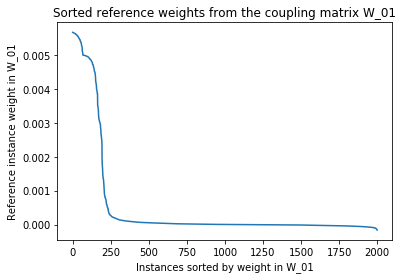

In [36]:
# Map the top assigned reference weights to the associated instance labels
# and select top 2 * n_ref_c. This tells us what the labels were of the reference 
# instances with the highest weights in the coupling matrix W_01.
# Ideally this would correspond to instances from the baseball and hockey 
# classes in the reference set (labels 9 and 10).
inds_ref_sort = np.argsort(w_ref)[::-1]
y_sort = y_ref[inds_ref_sort][:2 * n_ref_c]

# And indeed, we can see that we mainly matched with the correct reference instances!
correct_match = np.array([y in [9, 10] for y in y_sort]).mean()
print(f'The top {100 * correct_match:.2f}% couplings from the top coupled {2 * n_ref_c} instances '
      'come from the baseball and hockey classes!')

# We can also easily see from the sorted coupling weights that the test statistic 
# focuses on just the baseball and hockey classes in the reference set and then
# the weights in the coupling matrix W_01 fall of a cliff.
plt.plot(w_ref[inds_ref_sort]);
plt.title('Sorted reference weights from the coupling matrix W_01');
plt.ylabel('Reference instance weight in W_01');
plt.xlabel('Instances sorted by weight in W_01');
plt.show()